# 料理の画像からアレルゲンを抽出

まず、`import`の手順を行う。<br>
実際チームメンバーのパソコンで実装したところ、<br>
`from keras import datasets, layers, models, losses`時点では<br>
tensorflowのバージョンの違いが観測され、<br>
tensorflow.kerasではなくkerasから`import`することになった。<br>

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import tensorflow as tf

from keras import datasets, layers, models, losses
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.experimental.AUTOTUNE

次に素材を導入する。出力から見ると、写真が正しく利用可能になった。ただし、`images`から抽出するべきである。<br>
以下のようにモデルの中間層を設置する。<br>
ただし、GPUを用いて学習のを確保すること。

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.
Epoch 1/10


/home/jdh/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - accuracy: 0.0403 - loss: 4.4393 - val_accuracy: 0.1606 - val_loss: 3.7126
Epoch 2/10
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - accuracy: 0.1411 - loss: 3.7165 - val_accuracy: 0.2698 - val_loss: 3.0354
Epoch 3/10
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - accuracy: 0.2683 - loss: 3.0181 - val_accuracy: 0.3809 - val_loss: 2.5920
Epoch 4/10
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.5189 - loss: 1.8773 - val_accuracy: 0.5094 - val_loss: 2.3606
Epoch 5/10
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.7955 - loss: 0.7646 - val_accuracy: 0.4892 - val_loss: 3.3317
Epoch 6/10
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.8991 - loss: 0.3576 - val_accuracy: 0.5122 - val_loss: 3.7463
Epoch 7/10
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - accuracy: 0.9283 - loss: 0.2498 - val_accuracy: 0.5369 - val_loss: 3.8513
Epoch 8/10
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.9391 - loss: 0.21

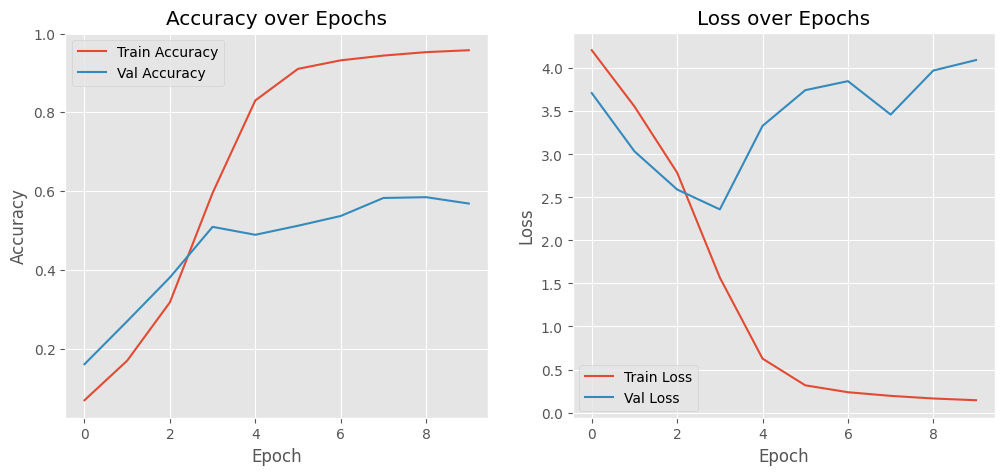

In [13]:
# 1. Load local food-101 dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'/home/jdh/UOsaka/b2_cv_lab/food-101/images',
    image_size=(224, 224),
    batch_size=64,
    shuffle=True,
    label_mode="categorical",
    seed=123,
    validation_split=0.2,
    subset="training"
)

class_names = train_dataset.class_names
num_classes = len(class_names)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'/home/jdh/UOsaka/b2_cv_lab/food-101/images',
    image_size=(224, 224),
    batch_size=64,
    shuffle=False,
    label_mode="categorical",
    seed=123,
    validation_split=0.2,
    subset="validation"
)
    
# 2. Build a simple CNN model
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Use num_classes here
])

# 3. Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# 5. Save the model
model.save('food-101_model.keras')
print("✅ Training complete, model saved as 'food-101_model.keras'!")

# 6. Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 7. Predict a single image
def predict_single_image(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    print(f'Predicted class: {predicted_class} (confidence: {confidence:.2f})')

# Load class names from dataset
class_names = train_dataset.class_names

# Example usage
# predict_single_image(model, 'path/to/your/test_image.jpg', class_names)